**bold text**# Case Study 2

In this case study, we will explore using  mean-squared displacement to quantify the motility of organelles. The mean-squared displacement measures the displacement of a particle for a given duration of time. When plotted on a log-log scale, the slope of the mean-squared displacement curve indicates the type of motility, where a slope of 0 indicates a stationary particle (x^2=C^2), a slope of 1 indicates diffusion (x^2=2Dt), and a slope of 2 indicates processive movement (x^2=v^2 t^2). We explored this concept in Problem Set 1.

Here, we will examine the trajectories of lysosomes in neurons. Lysosomes are responsible for packaging and degrading damaged proteins and organelles. The lysosomes were labeled using Lysotracker -- a fluoroscent compound that enriches in acidic organelles -- and imaged using a spinning disk confocal fluorescence microscope (see *.tif). The ImageJ plugin Trackmate was used to calculate the position of the lysosomes in each frame of the movie, and then link the positions into trajectories. 

The code below loads the tracking data (SpotsInTracksStatistics.csv) and plots the positions and mean-squared displacement for one of the trajectories. The trajectory to be plotted is specified by the variable "k_track".

Using mean-squared displacement analysis, characterize the motility in tracks 5, 9, 11, 12, 13, and 21 as stationary, diffusive, processive, or a combination of these modes. Estimate the diffusion coefficient using the primarily diffusive trajectories, and the velocity of the primarily processive trajectories.


In [50]:
# mount data folder 
#uncomment these lines if running using google colab
## - you will need to edit the os.chdir command depending on the directory you have the files stored in
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
os.chdir("/content/gdrive/MyDrive/Fall 2020/CaseStudies/")
#!ls "/content/gdrive/MyDrive"

# load libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import math


Mounted at /content/gdrive


In [51]:
# Define variables
track_id = np.empty((0))
frame = np.empty((0))
time = np.empty((0))
x = np.empty((0))
y = np.empty((0))

In [52]:
# Read in data from csv file
filename = "SpotsInTracksStatistics.csv" #table containing tracking results
exp_time = 0.5 #Exposure time [s]

data = open(filename)
csv_reader = csv.reader(data)

# Initialize row counter
i = 0
    
# Read file row by row
for row in csv_reader: 
    
    # Skip the first line (contains header)
    if i <= 1:
        
      i += 1
      continue
    
    try:
        track_id=np.append(track_id,int(row[2]))
        frame=np.append(frame,int(row[8]))
        time=np.append(time,float(row[7]))
        x=np.append(x,float(row[4]))
        y=np.append(y,float(row[5]))
        #track_id.append(row[2]) # first column, track id
        #frame.append(row[8]) # frame
        #time.append(float(row[7])) # time (s)
        #x.append(float(row[4])) # x position (um)
        #y.append(float(row[5])) #y position (um)
  

    except ValueError:
      continue

data.close()


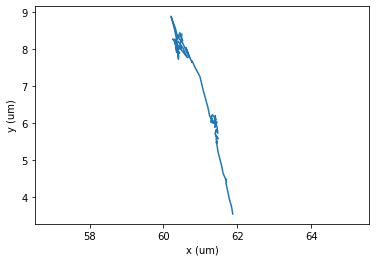

In [53]:
#choose a trajectory to analyze
k_track = 21 # 21 #12 #5 #9 #5 #21 #9 #13 #12 #11 #5 #21 #9 #13 #21 #number of trajectory to analyze 
jt=np.where(track_id==k_track) #indices corresponding to track
track_id[jt]

#plot trajectory
plt.plot(x[jt],y[jt])
plt.xlabel("x (um)")
plt.ylabel("y (um)")
plt.axis('equal')
plt.show()

In [54]:
#Calculate the Mean-Squared Displacement for a single trajectory
Ndat = np.size(jt) #no. of points in trajectory
# K = np.arange(3,math.ceil(0.2*Ndat)) #Delays [frames]
# K = np.arange(1,math.ceil(0.2*Ndat)) #Delays [frames]
K = np.arange(3,math.ceil(0.5*Ndat)) #Delays [frames]

N=np.empty(np.size(K)) #Number of segments for each delay
msd=np.empty(np.size(K)) #Mean-Squared Displacement
msd_std=np.empty(np.size(K)) #Standard Deviation of the MSD

xk=x[jt] #x positions for the specified trajectory
yk=y[jt] #y positions for the specified trajectory

for j in range(np.size(K)): #for each delay
  k = K[j] #delay
  dispsqk = [] #displacement squared
        
  #for kd in range(Ntraj): #for each trajectory             
  if k < (Ndat - 1):
    jmax = min(Ndat, max(K)*4)
    j0 = list(range(1,(jmax-k)))
    j1 = list(range((k + 1), jmax))
                          
    dkd = (xk[j1]-xk[j0])**2+(yk[j1]-yk[j0])**2 #calculate MSD
                          
    dispsqk = np.concatenate((dispsqk, dkd), axis=0) 
            
    #if k == 1:
      # msd_delay1 = np.concatenate((msd_delay1, dispsqk), axis=1) #msd for 1 frame delay (not currently used)  
        
    jk=np.where(np.isnan(dispsqk)==False)
        
    N[j] = np.size(dispsqk[jk]) #no. of sample points for each delta_t
    msd[j] = sum(dispsqk[jk])/N[j] #mean MSD for each delta_t
    msd_std[j] = np.std(dispsqk[jk]) #standard deviation for each delta_t
    msd_sem=msd_std/(N**0.5)

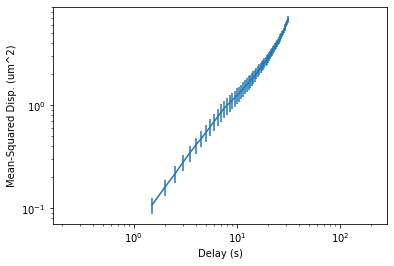

In [55]:
#plot mean-squared displacement
#plt.plot(K*exp_time,msd)
plt.errorbar(K*exp_time,msd,yerr=msd_sem,xerr=None)
#plt.plot(K*exp_time,msd-msd_std)
plt.xlabel("Delay (s)")
plt.ylabel("Mean-Squared Disp. (um^2)")
plt.xscale("log")
plt.yscale("log")
plt.axis('equal')
plt.show()

In [56]:
#polynomial fit to find slope
p = np.polyfit(np.log10(K*exp_time),np.log10(msd),1)
print(p[1])
print(p[0]) #slope on log-log plot

#polynomial fit to find non-log slope
p1 = np.polyfit(K*exp_time,msd,1)
print(p1[0]) #slope on log-log plot

-1.1893502721508333
1.292305274507492
0.20322431478097433


Velocity =  0.07365761918954193  um/s
D =  0.006046158561703068  um^2/s
tracking_uncertainty =  0.5559565877711771  um


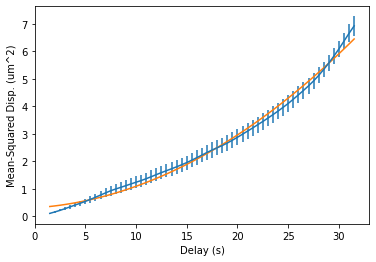

In [57]:
#polynomial fit to linear data to solve for D, v
# <dx^> = (tracking uncertainty)^2 + 4*D*dt + velocity^2*dt^2

# for processive trajectory
if p[0]>1.1:
  p_lin = np.polyfit(K*exp_time,msd,2) 
  velocity = math.sqrt(p_lin[0])
  D = p_lin[1]/4
  tracking_uncertainty = math.sqrt(max(0,p_lin[2]))
  print('Velocity = ',velocity,' um/s')
  print("D = ",D," um^2/s")
  print('tracking_uncertainty = ',tracking_uncertainty,' um')
else:#if p[0]<=1.1 & p[0]>0.5 #diffusive/stationary trajectory
  p_lin = np.polyfit(K*exp_time,msd,1) 
  #velocity = math.sqrt(p_lin[0])
  D = p_lin[0]/4
  tracking_uncertainty = math.sqrt(max(0,p_lin[1]))
  #print('Velocity = ',velocity,' um/s')
  print("D = ",D," um^2/s")
  print('tracking_uncertainty = ',tracking_uncertainty,' um')

#plot fit
plt.errorbar(K*exp_time,msd,yerr=msd_sem,xerr=None)
plt.plot(K*exp_time,np.polyval(p_lin,K*exp_time))
plt.xlabel("Delay (s)")
plt.ylabel("Mean-Squared Disp. (um^2)")
#plt.xscale("log")
#plt.yscale("log")
#plt.axis('equal')
plt.show()
